Best k: 5


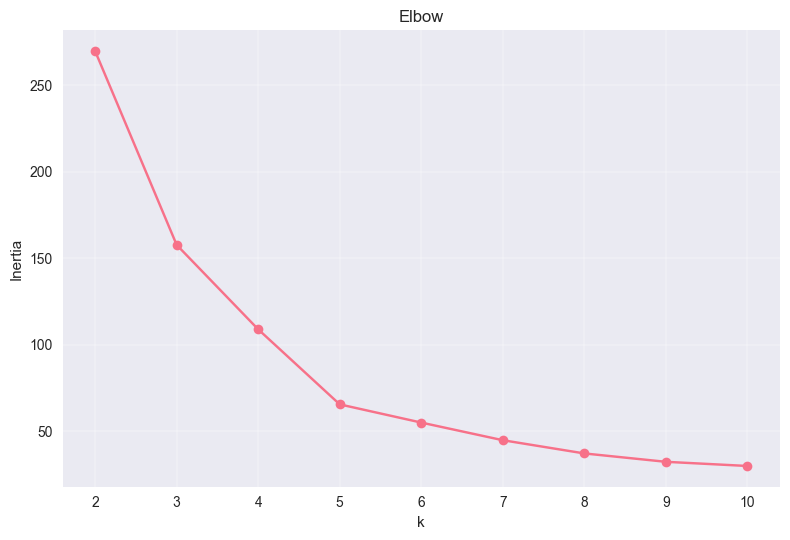

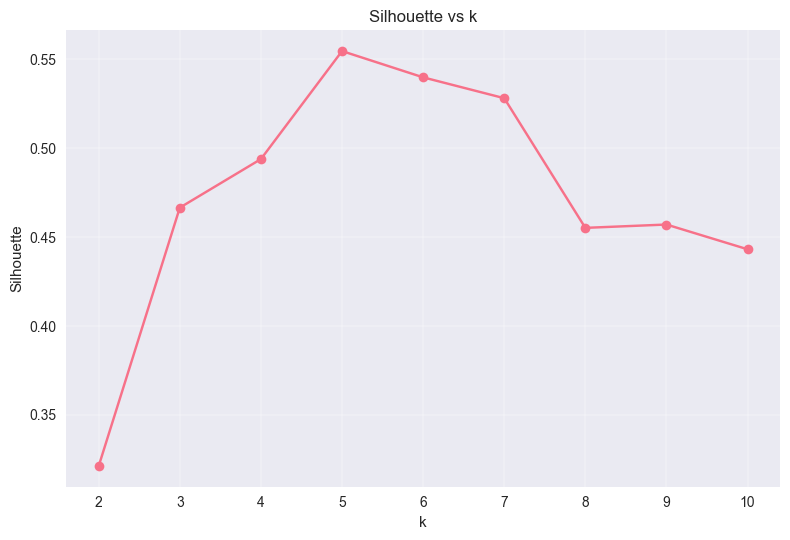

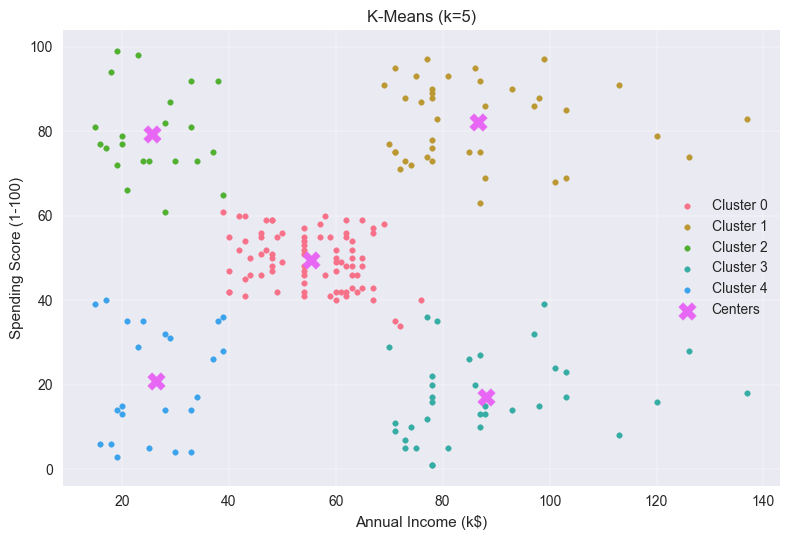

In [29]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ganti path jika perlu
df = pd.read_csv("data/Mall_Customers.csv")

def find_column(df, patterns):
    for pat in patterns:
        rx = re.compile(pat, re.I)
        for c in df.columns:
            if rx.search(c): return c
    return None

income = find_column(df, [r"annual\s*income", r"\bincome\b"]) or "Annual Income (k$)"
spend  = find_column(df, [r"spending\s*score", r"\bspending\b.*\bscore\b"]) or "Spending Score (1-100)"
feature_cols = [income, spend]

X_orig = df[feature_cols].dropna()
X = StandardScaler().fit_transform(X_orig)

k_vals = range(2,11)
rows, inertias, sils = [], [], []
for k in k_vals:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm="elkan")
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels)
    sils.append(sil)
    rows.append({"k": k, "inertia": km.inertia_, "silhouette": sil})
res = pd.DataFrame(rows).sort_values(["silhouette","inertia"], ascending=[False,True])
best_k = int(res.iloc[0]["k"])
print("Best k:", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10, algorithm="elkan").fit(X)
centers = km.cluster_centers_
centers_orig = StandardScaler().fit(X_orig).inverse_transform(centers)  # Perhatikan: gunakan scaler yang sama jika disimpan

# Plot elbow
plt.figure()
plt.plot(list(k_vals), inertias, marker="o"); plt.xlabel("k"); plt.ylabel("Inertia")
plt.title("Elbow"); plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

# Plot silhouette vs k
plt.figure()
plt.plot(list(k_vals), sils, marker="o"); plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Silhouette vs k"); plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

# Scatter klaster (pakai unit asli untuk sumbu)
labels = km.labels_
plt.figure()
for c in range(best_k):
    m = (labels==c)
    plt.scatter(X_orig.iloc[m,0], X_orig.iloc[m,1], s=16, label=f"Cluster {c}")
plt.scatter(centers_orig[:,0], centers_orig[:,1], s=160, marker="X", label="Centers")
plt.xlabel(feature_cols[0]); plt.ylabel(feature_cols[1]); plt.legend(); plt.grid(True, linewidth=0.3)
plt.title(f"K-Means (k={best_k})"); plt.tight_layout(); plt.show()

Default: {'eps': 0.2, 'min_samples': 5, 'n_clusters': 2, 'n_noise': 0, 'homogeneity': 1.0, 'completeness': 1.0, 'v_measure': 1.0, 'ARI': 1.0, 'AMI': 1.0, 'silhouette_non_noise': 0.3911598537138403}


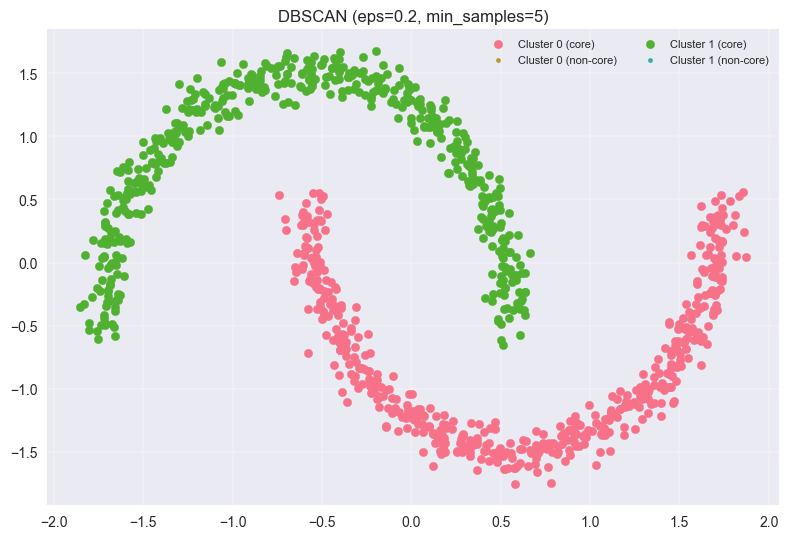

     eps  min_samples  n_clusters  n_noise  homogeneity  completeness  \
0   0.05            3          69      186     0.815554      0.152548   
1   0.05           10           3      970     0.030669      0.126764   
2   0.05           20           0     1000     0.000000      1.000000   
3   0.10            3           2       14     0.986207      0.902896   
4   0.10           10           7       57     0.943317      0.409546   
5   0.10           20           6      850     0.153928      0.155466   
6   0.30            3           2        0     1.000000      1.000000   
7   0.30           10           2        0     1.000000      1.000000   
8   0.30           20           2        0     1.000000      1.000000   
9   0.50            3           2        0     1.000000      1.000000   
10  0.50           10           2        0     1.000000      1.000000   
11  0.50           20           2        0     1.000000      1.000000   

    v_measure       ARI       AMI  silhouette_non_

In [30]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_completeness_v_measure, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
X = StandardScaler().fit_transform(X)

def silhouette_non_noise(X, labels):
    m = labels != -1
    if m.sum()<2 or len(np.unique(labels[m]))<2: return np.nan
    return silhouette_score(X[m], labels[m])

def run(eps, ms):
    db = DBSCAN(eps=eps, min_samples=ms).fit(X)
    lab = db.labels_
    n_clusters = len(set(lab)) - (1 if -1 in lab else 0)
    n_noise = int((lab==-1).sum())
    h,c,v = homogeneity_completeness_v_measure(y, lab)
    ari = adjusted_rand_score(y, lab)
    ami = adjusted_mutual_info_score(y, lab)
    sil = silhouette_non_noise(X, lab)
    return db, {"eps":eps,"min_samples":ms,"n_clusters":n_clusters,"n_noise":n_noise,
                "homogeneity":h,"completeness":c,"v_measure":v,"ARI":ari,"AMI":ami,"silhouette_non_noise":sil}

# Default
db, m = run(0.2, 5)
print("Default:", m)

# Visual: core=besar, non-core=kecil, noise=hitam
labels = db.labels_
core_mask = np.zeros_like(labels, dtype=bool)
core_idx = getattr(db, "core_sample_indices_", [])
core_mask[core_idx] = True

plt.figure()
first_noise=True
for k in sorted(set(labels)):
    cl = labels==k
    if k == -1:
        plt.scatter(X[cl,0], X[cl,1], s=10, color="k", label="Noise" if first_noise else None)
        first_noise=False
    else:
        plt.scatter(X[cl & core_mask,0], X[cl & core_mask,1], s=36, label=f"Cluster {k} (core)")
        plt.scatter(X[cl & ~core_mask,0], X[cl & ~core_mask,1], s=10, label=f"Cluster {k} (non-core)")
plt.title("DBSCAN (eps=0.2, min_samples=5)"); plt.legend(ncol=2, fontsize=8)
plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

# Grid eksperimen
eps_list = [0.05, 0.1, 0.3, 0.5]
min_samples_list = [3, 10, 20]
rows=[]
for e in eps_list:
    for ms in min_samples_list:
        _, met = run(e, ms)
        rows.append(met)
exp = pd.DataFrame(rows)
print(exp.sort_values(["eps","min_samples"]))